<a href="https://colab.research.google.com/github/papyDick/esgf-melbourne/blob/main/Copie_de_TP4_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Project (TP4): Melbourne Temperation Prediction

#### Groupe Members: 
##### ***Bah Ibrahima Sory Bhoundoubhe***
##### ***BIRO Yawa grace***
##### ***OGANDAGA-ABAGA Rosaly-fiestane-denysia***
##### ***DICKO Alhassane***

### Importing the libraries

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

# Getting the data

In [64]:
import urllib.request
import pandas as pd
from io import StringIO


def get_melbourne_data() -> pd.DataFrame:
    '''
    Returns a dataframe of the melbourne data set.
    :return: pd.DataFrame
    '''

    # URL of the raw csv data to download
    raw_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"

    # Get the earthquake data from the API
    response = urllib.request.urlopen(raw_url)

    # Decode earthquake data
    response = response.read().decode('utf-8')

    # Return as a pandas dataframe
    data = pd.read_csv(StringIO(response))

    # Cast the date column to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    return data

In [85]:
import pandas as pd
dataset = get_melbourne_data()

In [86]:
dataset.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [87]:
dataset.info()
dataset=dataset.iloc[:,1:]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


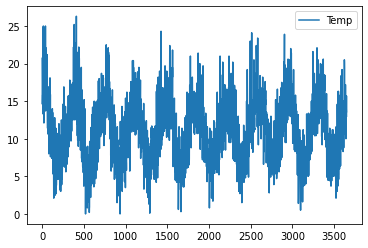

In [88]:
dataset.plot();

# Data pre-processing

In [89]:
np.random.seed(7)

In [90]:
dataset = dataset[['Temp']].values

In [91]:
dataset.shape

(3650, 1)

In [92]:
dataset[:10]

array([[20.7],
       [17.9],
       [18.8],
       [14.6],
       [15.8],
       [15.8],
       [15.8],
       [17.4],
       [21.8],
       [20. ]])

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [94]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2445 1205


In [95]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [96]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [97]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0] , testX.shape[1], 1))

In [98]:
trainX.shape

(2442, 2, 1)

# LSTM Neural Network

In [99]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))

model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])


# Tain the model
start = time.time()
model.fit(trainX, trainY, 
          epochs=100, 
          batch_size=1, 
          verbose=1, shuffle=False, 
          validation_data=(testX, testY))
          
end = time.time()

print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/100
2442/2442 [==============================] - 9s 3ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 2/100
2442/2442 [==============================] - 6s 2ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 3/100
2442/2442 [==============================] - 6s 3ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 4/100
2442/2442 [==============================] - 6s 3ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 5/100
2442/2442 [==============================] - 7s 3ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 6/100
2442/2442 [==============================] - 7s 3ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 7/100
2442/2442 [==============================] - 6s 2ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 8/100
2442/2442 [==============================] 

# Compute RMSE

In [100]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0,:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.91 RMSE
Test Score: 2.92 RMSE


In [102]:
testScoreList=[]


for i in range(3):
    testScoreList.append([math.sqrt(mean_squared_error(testY[0][i*365:i*365+90], testPredict[i*365:i*365+90])),
                          math.sqrt(mean_squared_error(testY[0][i*365:i*365+180], testPredict[i*365:i*365+180])),
                          math.sqrt(mean_squared_error(testY[0][i*365:i*365+365], testPredict[i*365:i*365+365]))])


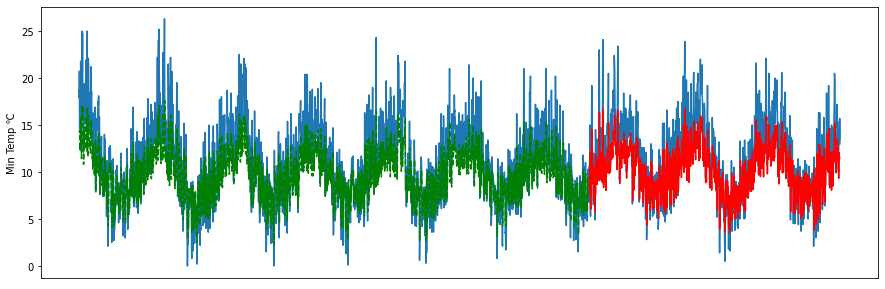

In [ ]:
%matplotlib inline
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize= [15, 5])
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, color='green', linestyle='dashed')
plt.plot(testPredictPlot, color='red')
plt.ylabel('Min Temp ℃')
plt.xticks([])
plt.show()
#original dataset in blue 
#predictions for the training dataset in green
#predictions on the unseen test dataset in red

RESULTATS

# ESGF Melbourne (dev)

## Data

Minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

![Daily temperature evolution](docs/pics/temperature_evolution.png "Daily Temperature Evolution")

## Objective

We want to build a model able to predict the **daily** temperature in Melbourne over the **next year**.

## Evaluation

Fit one or more models using the data strictly anterior to the evaluation years 
`t=1987`, `t=1988` and `t=1989` in order to predict the daily temperature 
during the year `t=1987`, `t=1988` and `t=1989` respectively.

### Results

Choose a suitable metric to evaluate the performance of your models. 
Report the metric in the following table. 

For each evaluation year `t`, you must report the performance considering `k=3`, `k=6` and `k=12` months of data following `t`.


|   **Evaluation year** 	| **Next 3 months** 	| **Next 6 months** 	| **Next 12 months** 	|
|:---------------------:	|:-----------------:	|:-----------------:	|:------------------:	|
|        **1987**       	|       rmse =  3.182	|    rmse =  3.274    	|     rmse =  2.881    	|
|        **1988**       	|       rmse =  3.442 	|    rmse =  3.661    	|        rmse =  3.020 	|
|        **1989**       	|       rmse =  2.889 	|     rmse =  3.140   	|         rmse =  2.782  	|